In [1]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
from torch.optim import AdamW
from copy import deepcopy
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

In [2]:
# Define the Gaussian function
def gaussian(x, mu, sigma, max_amp):
    return max_amp * np.exp(-0.5 * ((x - mu) / sigma)**2)

### Environment with No History

In [3]:
class PendulumDiscreteStateAction(gym.Wrapper):
    """
    A wrapper class that discretizes the observation and action spaces of the Pendulum environment.
    """

    def __init__(self, env: gym.Env, nvec_u: int, sigma: float):
        """
        Initializes the PendulumDiscreteStateAction wrapper.

        Parameters:
        - env: The original Pendulum environment.
        - nvec_s: A list of integers representing the number of discrete values for each dimension of the observation space.
        - nvec_u: A list of integers representing the number of discrete values for each dimension of the action space.
        """
        super(PendulumDiscreteStateAction, self).__init__(env)

        self.env = env
        self.nvec_u = nvec_u

        # Create a Discrete action space
        self.action_space = gym.spaces.Discrete(nvec_u)

        # Define the possible actions
        kernel = gaussian(
            np.linspace(0, 1, nvec_u // 2), 0, sigma, self.env.action_space.high[0]
        )
        self.actions = (-kernel).tolist() + [0] + np.flip(kernel).tolist()
        # self.actions = [-2.0, -1.0, -0.5, -0.15, -0.05, 0.0, 0.05, 0.15, 0.5, 1.0, 2.0]

    def step(self, action: int) -> tuple[np.ndarray[float], float, bool, dict]:
        """
        Takes a step in the environment.

        Parameters:
        - action: The discrete action.

        Returns:
        - The next discrete observation, reward, termination flag, truncated flag, and additional information.
        """
        action = self.actions[action]
        obs, reward, terminated, truncated, info = self.env.step([action])
        reward = reward / 16.2736044  # normalize the reward between -1 and 1
        obs: np.ndarray[float] = (
            obs / self.env.observation_space.high
        )  # normalize the observation between -1 and 0
        return obs, reward, terminated, truncated, info

    def reset(self) -> tuple[np.ndarray[float], dict]:
        """
        Resets the environment.

        Returns:
        - The initial discrete observation and additional information.
        """
        obs, info = self.env.reset()
        obs: np.ndarray[float] = obs / self.env.observation_space.high
        return obs, info

### Create the Q Neural Network

In [4]:
class QNetwork(nn.Module):
    def __init__(self, nvec_s, nvec_u):
        super(QNetwork, self).__init__()

        self.fc1 = nn.Linear(nvec_s, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, nvec_u)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Create the Replay Memory

In [5]:
class ReplayMemory:
    def __init__(self, capacity, env: gym.Env, device: torch.device):
        """
        Initializes the ReplayMemory class.

        Parameters:
        - capacity: The maximum capacity of the replay memory.
        - env: The environment used to define the state and action spaces.
        - device: The device (CPU or GPU) used for tensor operations.
        """
        self.position = 0
        self.size = 0
        self.capacity = capacity
        self.device = device

        self.n_states = env.observation_space.shape  # Number of dimensions in the state space
        self.n_actions = env.action_space.n  # Number of discrete actions

        # Initialize arrays to store the replay memory
        self.states = np.zeros((capacity, *self.n_states))
        self.actions = np.zeros((capacity))
        self.rewards = np.zeros(capacity)
        self.next_states = np.zeros((capacity, *self.n_states))
        self.terminated = np.zeros(capacity)
        self.truncated = np.zeros(capacity)

    def push(self, state:np.ndarray, action:int, next_state:np.ndarray, reward:float, terminated: bool, truncated:bool):
        """
        Adds a transition to the replay memory.

        Parameters:
        - state: The current state.
        - action: The action taken.
        - next_state: The next state.
        - reward: The reward received.
        - terminated: Whether the episode terminated after this transition.
        - truncated: Whether the episode was truncated after this transition.
        """
        self.states[self.position] = state.flatten()
        self.actions[self.position] = action
        self.next_states[self.position] = next_state.flatten()
        self.rewards[self.position] = reward
        self.terminated[self.position] = terminated
        self.truncated[self.position] = truncated

        self.position = (self.position + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size):
        """
        Samples a batch of transitions from the replay memory.

        Parameters:
        - batch_size: The size of the batch to sample.

        Returns:
        - states: The sampled states.
        - actions: The sampled actions.
        - next_states: The sampled next states.
        - rewards: The sampled rewards.
        - terminated: The sampled termination flags.
        - truncated: The sampled truncation flags.
        """
        indices = np.random.choice(self.size, batch_size, replace=False)

        states = torch.tensor(self.states[indices], dtype = torch.float32, device=self.device)
        actions = torch.tensor(self.actions[indices], dtype = torch.int64, device=self.device)
        next_states = torch.tensor(self.next_states[indices], dtype = torch.float32, device=self.device)
        rewards = torch.tensor(self.rewards[indices], dtype = torch.float32, device=self.device)
        terminated = torch.tensor(self.terminated[indices], dtype = torch.float32, device=self.device)
        truncated = torch.tensor(self.truncated[indices], dtype = torch.float32, device=self.device)

        return states, actions, next_states, rewards, terminated, truncated

    def __len__(self):
        """
        Returns the current size of the replay memory.
        """
        return len(self.size)

In [6]:
class Agent:
    def __init__(
        self,
        env: gym.Env,
        gamma=0.99,
        alpha=0.0003,
        initial_epsilon=1,
        min_epsilon=0.1,
        decay_rate=0.9999,
        batch_size=64,
        n_rollouts=2000,
        capacity=100000,
        device: torch.device = torch.device("cpu"),
    ):
        """
        Initializes the Agent class.

        Parameters:
        - env: The environment in which the agent will interact.
        - gamma: Discount factor for future rewards.
        - alpha: Learning rate for the optimizer.
        - initial_epsilon: Initial value for epsilon in epsilon-greedy exploration.
        - min_epsilon: Minimum value for epsilon.
        - decay_rate: Rate at which epsilon decays over time.
        - batch_size: Number of samples to use in each training iteration.
        - n_rollouts: Number of rollouts to collect during training.
        - capacity: Capacity of the replay memory.
        - device: Device on which to perform computations (CPU or GPU).
        """
        self.env = env
        self.device = device
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = initial_epsilon
        self.batch_size = batch_size
        self.n_rollouts = n_rollouts

        self.epsilon = 1
        self.min_epsilon = min_epsilon
        self.decay_rate = decay_rate

        self.replay_memory = ReplayMemory(capacity, env, device)
        self.q_network = QNetwork(
            env.observation_space.shape[0], env.action_space.n
        ).to(device)
        self.target_network = deepcopy(self.q_network)
        self.optimizer = AdamW(self.q_network.parameters(), lr=alpha)

        self.n_states = env.observation_space.shape[
            0
        ]  # Number of dimensions in the state space

        # for metrics
        self.n_time_steps = 0  # number of time steps
        self.episodes = 0  # number of episodes
        self.n_updates = 0  # number of gradient updates
        self.best_reward = -np.inf


    def get_action(self, obs, greedy=False):
        """
        Returns an action based on the current observation.

        Parameters:
        - obs: The current observation.
        - greedy: Whether to choose the action greedily or using epsilon-greedy exploration.

        Returns:
        - The chosen action.
        """
        if not greedy and np.random.rand() < self.epsilon:
            return np.random.randint(self.env.action_space.n)
        obs = torch.tensor(obs, dtype=torch.float32, device=self.device).unsqueeze(0)
        self.q_network.eval()
        with torch.no_grad():
            q_values: torch.Tensor = self.q_network(obs)
            return q_values.argmax().item()

    def sample_experience(self):
        """
        Samples a batch of experiences from the replay memory.

        Returns:
        - A batch of experiences.
        """
        return self.replay_memory.sample(self.batch_size)

    def update_target(self):
        """
        Updates the target network by copying the weights from the Q network.
        """
        self.target_network.load_state_dict(self.q_network.state_dict())

    def collect_rollouts(self):
        """
        Collects rollouts by interacting with the environment.

        Returns:
        - The average reward per episode.
        """
        obs, info = self.env.reset()
        terminated = False
        truncated = False
        rewards = 0
        episodes = 0
        for _ in range(self.n_rollouts):
            action = self.get_action(obs, greedy=False)
            next_obs, reward, terminated, truncated, _ = self.env.step(action)
            self.replay_memory.push(
                obs, action, next_obs, reward, terminated, truncated
            )  # save the transition
            obs = next_obs
            rewards += reward
            self.n_time_steps += 1
            if terminated or truncated:
                episodes += 1
                self.episodes += 1
                obs, info = self.env.reset()

            self.epsilon = max(
                self.min_epsilon, self.decay_rate * self.epsilon
            )  # decrease epsilon

        return rewards / episodes  # return the average reward per episode

    def learn(self, epochs):
        """
        Performs the learning process.

        Parameters:
        - epochs: Number of epochs to train for.

        Returns:
        - The average loss.
        """
        self.q_network.train()

        average_loss = 0
        for i in range(epochs):
            obs, action, next_obs, reward, terminated, truncated = (
                self.sample_experience()
            )
            q_values: torch.Tensor = self.q_network(obs)
            next_q_values = self.target_network(next_obs)

            q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
            next_q_value = next_q_values.max(1).values
            target = reward + self.gamma * next_q_value * (1 - terminated) * (
                1 - truncated
            )

            loss = F.smooth_l1_loss(q_value, target)

            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 10)
            self.optimizer.step()
            
            average_loss += (loss.item() - average_loss) / (i + 1)
            self.n_updates += 1

            if self.n_updates % 1000 == 0:
                self.update_target()

        return average_loss

    def evaluate(self, n_steps):
        """
        Evaluates the agent's performance on the environment.

        Parameters:
        - n_steps: Number of steps to evaluate for.

        Returns:
        - The average reward per episode.
        """
        self.q_network.eval()
        rewards = 0
        episodes = 0
        with torch.no_grad():
            obs, info = self.env.reset()
            for _ in range(n_steps):
                action = self.get_action(obs, greedy=True)
                obs, reward, terminated, truncated, _ = self.env.step(action)
                rewards += reward

                if terminated or truncated:
                    episodes += 1
                    self.env.reset()
                    
        rewards /= episodes   
        if rewards > self.best_reward:
            self.best_reward = rewards
            torch.save(self.q_network.state_dict(), "dqn_best_model.pth")
            print("New best model saved!")
        return rewards

    def train(self, epochs):
        """
        Trains the agent.

        Parameters:
        - epochs: Number of epochs to train for.
        """
        self.writer = SummaryWriter(log_dir="dqn_logs/DQN_2")

        pbar = tqdm(range(epochs))
        for i in pbar:
            rewards = self.collect_rollouts()
            loss = self.learn(int(self.n_rollouts/2))
            eval_reward = self.evaluate(1000)

            pbar.set_description(
                f"Iteration {i+1} || Reward: {rewards:.3f} || Eval Reward: {eval_reward :.3f} || Loss: {loss:.3f} || Epsilon: {self.epsilon:.2f} || Time steps: {self.n_time_steps} || N updates: {self.n_updates}"
            )
            self.writer.add_scalar("Training/Loss", loss, self.n_updates)
            self.writer.add_scalar(
                "Training/Rollout: Mean Episode Reward", rewards, self.n_updates
            )
            self.writer.add_scalar(
                "Evaluation/Mean Episode Reward", eval_reward, self.n_updates
            )

In [7]:
env = gym.make("Pendulum-v1")
env._max_episode_steps = 500
env = PendulumDiscreteStateAction(env, 11, 0.4)


In [8]:
agent = Agent(env)

In [9]:
# agent.train(30)

In [10]:
import matplotlib.pyplot as plt

env = gym.make("Pendulum-v1",
            #    render_mode='human'
               )
env._max_episode_steps = 500
env = PendulumDiscreteStateAction(env, 11, 0.4)

agent = Agent(env)
agent.q_network.load_state_dict(torch.load("models/deep_q_learning/dqn_best_model.pth"))

rewards = []
thetas = []
actions = []
tot_reward = 0
n_episodes = 100
n_steps= 0
for _ in range(n_episodes):
    obs, info = env.reset()
    terminated = False
    truncated = False
    while not terminated and not truncated:
        with torch.no_grad():
            action = agent.get_action(obs, greedy = True)
            # print(action)
            obs, reward, terminated,  truncated, info = env.step(action)
            x = obs[0] * env.observation_space.high[0]
            y = obs[1] * env.observation_space.high[1]
            theta = np.arctan2(y, x)
            thetas.append(theta)
            rewards.append(reward)
            tot_reward += reward
            n_steps+=1
            # env.render()
print("Total reward: ", tot_reward/n_episodes)


KeyboardInterrupt: 

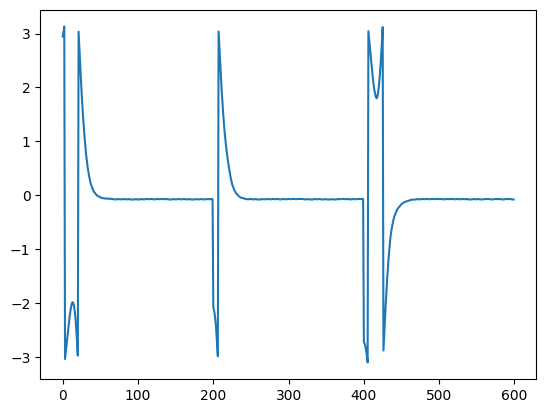

In [ ]:
plt.plot(thetas[:600])
plt.title()

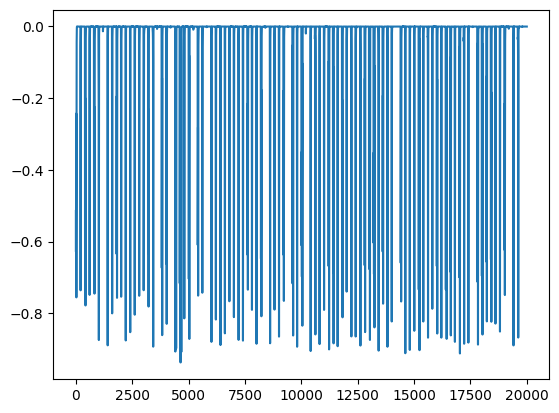

In [ ]:

plt.plot(rewards[0:1500])